<a href="https://colab.research.google.com/github/alice412/Transaction-Fraud-detection/blob/main/%D0%A2%D1%83%D1%85%D0%B2%D0%B0%D1%82%D1%83%D0%BB%D0%BB%D0%B8%D0%BD%D0%B0_%D0%90_%D0%A0_%22%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_Transaction_Fraud_detection%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transaction Fraud detection

Мошенничество можно встретить во многих различных областях, таких как электронная коммерция, здравоохранение, платежные и банковские системы. Мошенничество - миллиардный рынок, и его объем увеличивается с каждым годом. Глобальный обзор экономических преступлений, проведенный PwC в 2018 году, показал, что половина (49 процентов) из 7 200 опрошенных компаний сталкивались с каким-либо мошенничеством.

Даже если мошенничество кажется опасным для бизнеса, его можно обнаружить с помощью интеллектуальных систем, таких как механизмы правил или машинное обучение.

Механизм правил - это программная система, которая выполняет одно или несколько бизнес-правил в рабочей среде выполнения. Эти правила обычно пишутся экспертами в предметной области для передачи знаний о проблеме механизму правил и оттуда в производство.

Правила отлично подходят для обнаружения некоторых видов мошенничества, но в некоторых случаях они могут вызывать множество ложных срабатываний или ложноотрицательных результатов, потому что у них есть предопределенные пороговые значения. Например, представим правило для отказа в транзакции, сумма которой превышает 10000 долларов для конкретного пользователя. Если этот пользователь является опытным мошенником, он / она может знать о том, что в системе будет установлен порог, и он / она может просто совершить транзакцию чуть ниже порогового значения (9999 долларов).

Для этого типа проблем ML приходит на помощь и снижает риск мошенничества и риск потери денег для бизнеса. Благодаря сочетанию правил и машинного обучения обнаружение мошенничества будет более точным и уверенным.

# Набор данных Banksim
Мы выявляем мошеннические транзакции из набора данных Banksim. Этот синтетически созданный набор данных состоит из платежей от разных клиентов, произведенных в разные периоды времени и с разными суммами. Для получения дополнительной информации о наборе данных вы можете посмотреть [страницу на  Kaggle](https://www.kaggle.com/ntnu-testimon/banksim1) для этого набора данных, где также есть ссылка на исходный документ.

# Описание колонок
* Step: Означает день со старта симуляции (максимум 180, т.е примерно 6 месяцев).
* Customer: Идентификатор покупателя
* zipCodeOrigin: ZIP код покупателя
* Merchant: Идентификатор продавца
* zipMerchant: ZIP код продавца
* Age: категоризованный возраст
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46-55,
5: 56-65,
6: > 65
U: Неизвестно (Unknown)
* Gender: Gender for customer
E: Компания (Enterprise),
F: Женский (Female),
M: Мужской (Male,
U: Неизвестно (Unknown)
* Category: Категория покупки
* Amount: Объем транзакции
* Fraud: 1 (fraud, мошенничество), 0 (обычная транзакция)

[Ссылка на набор данных](https://drive.google.com/file/d/1PFnTLIPx3lJ7pmf0JvVhjpWpZ8GsJTn7/view?usp=sharing)

# Задание
1. Проведите первичный анализ данных, сформулируйте эвристики для детекции фрода (аномалий), которые можно использовать в качестве базового решения. Приведите метрики качества для оценки вашего алгоритма.
2. Попробуйте получить решение лучше по метрикам (с помощью модели ML), чем эвристика, помните, что класс 1 (мошенничество) в целом скорее важнее, чем класс 0.
3. Изучите одну из техник балансировки выборки (например, [оверсемплинг с помощью метода SMOTE](https://habr.com/ru/post/461285/)) и попробуйте еще улучшить качество алгоритма.
4. Выберите лучший алгоритм по пунктам 1-2-3 и внесите часть тестовой выборки (с предсказанием) в вашу учебную базу, а затем постройте дэшборд в redash в котором будет отражена информация о количестве фродовых транзакций за неделю, а также будут выведены последние 10 фродовых транзакций, требующих проверки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import time
%matplotlib inline

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/bs140513_032310.csv'

In [ ]:
df_orign = pd.read_csv(path, sep=',', quotechar='\'')
df_orign.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


## Первичный анализ данных
Проверим датасет на наличие пропусков,
проведем оценку и оптимизацию типов данных, содержащихся в датасете 

In [ ]:
df_orign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  int64  
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  int64  
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 45.4+ MB


In [ ]:
df_orign.nunique()

step             180
customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         23767
fraud              2
dtype: int64

Поскольку zip-коды покупателя и продавца идентичны для каждой записи и не дают
нам полезной информации, удалим эти признаки из набора данных.

In [ ]:
df = df_orign.drop( ['zipcodeOri', 'zipMerchant'], axis=1)
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [ ]:
df['age'].replace({'U': '7'}, inplace=True)

In [ ]:
# добавляем в набор признаков категорию, которая будет учитывать 
# пол и возраст одновременно

df['age_gender'] = df['age'] + df['gender']
df.head() 

,step,customer,age,gender,merchant,category,amount,fraud,age_gender
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0,4M
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0,2M
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0,4F
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0,3M
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0,5M


In [ ]:
# оптимизируем набор данных по типам 
df = df.astype({
    'step': 'int32',
    'age': 'int8',
    'fraud': 'int8'
})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   step        594643 non-null  int32  
 1   customer    594643 non-null  object 
 2   age         594643 non-null  int8   
 3   gender      594643 non-null  object 
 4   merchant    594643 non-null  object 
 5   category    594643 non-null  object 
 6   amount      594643 non-null  float64
 7   fraud       594643 non-null  int8   
 8   age_gender  594643 non-null  object 
dtypes: float64(1), int32(1), int8(2), object(5)
memory usage: 30.6+ MB


In [ ]:
df.describe()

,step,age,amount,fraud
count,594643.000000,594643.000000,594643.000000,594643.000000
mean,94.986827,3.014151,37.890135,0.012108
std,51.053632,1.335884,111.402831,0.109369
min,0.000000,0.000000,0.000000,0.000000
25%,52.000000,2.000000,13.740000,0.000000
50%,97.000000,3.000000,26.900000,0.000000
75%,139.000000,4.000000,42.540000,0.000000
max,179.000000,7.000000,8329.960000,1.000000


## Оценка данных в разрезе различных признаков

In [ ]:
df.groupby(['fraud']).describe().stack()

step            age         amount
fraud                                                   
0     count  587443.000000  587443.000000  587443.000000
      mean       95.054077       3.014790      31.847230
      std        51.038755       1.336325      31.470876
      min         0.000000       0.000000       0.000000
      25%        52.000000       2.000000      13.590000
      50%        97.000000       3.000000      26.610000
      75%       139.000000       4.000000      41.895000
      max       179.000000       7.000000    2144.860000
1     count    7200.000000    7200.000000    7200.000000
      mean       89.500000       2.962083     530.926551
      std        51.964331       1.298414     835.587112
      min         0.000000       0.000000       0.030000
      25%        44.750000       2.000000     159.980000
      50%        89.500000       3.000000     319.175000
      75%       134.250000       4.000000     548.977500
      max       179.000000       7.000000    8329.960000

Посмотрим на сотношение количества нормальных и фродовых сделок в общем количестве транзакций, а также в общей сумме транзакций

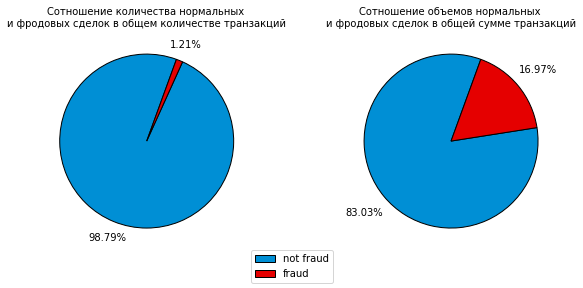

In [ ]:
fraud_part = df.groupby('fraud')[['fraud','amount']].agg({'fraud': lambda x: round(x.count()/df['fraud'].count()*100, 2),
                                                          'amount': lambda x: round(x.sum()/df['amount'].count()*100, 2)
                                                         })
clr = ['#008fd5', '#e50000']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].pie(x=fraud_part['fraud'], radius=1, startangle=70, colors = clr, wedgeprops={'edgecolor': 'black'}, 
            autopct='%2.2f%%', pctdistance=1.2, explode=(0, 0), shadow=False)
axes[1].pie(x=fraud_part['amount'], radius=1, startangle=70, colors = clr, wedgeprops={'edgecolor': 'black'}, 
            autopct='%2.2f%%', pctdistance=1.3, explode=(0, 0), shadow=False)
axes[0].set_title('Cотношение количества нормальных \nи фродовых сделок в общем количестве транзакций', fontsize='medium') 
axes[1].set_title('Cотношение объемов нормальных \nи фродовых сделок в общей сумме транзакций', fontsize='medium') 
fig.legend(loc='lower center', labels=['not fraud', 'fraud'], fontsize='medium')
plt.show()


*Данные по обычным и фродовым транзакциям в представленном датасете несбалансированы, это необходимо учесть при построении модели.*


### Оценка данных в разрезе распределения сумм транзаций.

In [ ]:
# Функция для вычисления порога для выбросов Q3 + 1.5*IQR

from scipy.stats import iqr

def up_border(arr):
  IQR_ = iqr(arr)
  Q_ = arr.quantile([0.75])
  ub = Q_.iloc[0] + 1.5*IQR_
  return ub

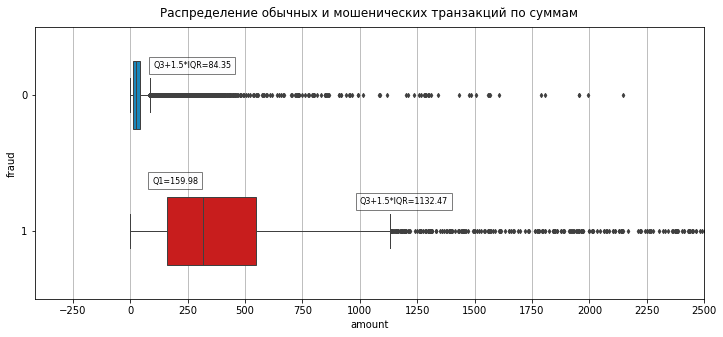

In [ ]:
up_border_0 = up_border(df[df['fraud']==0]['amount'])  
up_border_1 = up_border(df[df['fraud']==1]['amount'])
Q1_1 = df[df['fraud']==1]['amount'].quantile([0.25, 0.75]).iloc[0] 

clr_ = ['#008fd5', '#e50000']
fig, axes = plt.subplots(figsize=(12,5))

axes.grid(axis='x', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение обычных и мошенических транзакций по суммам', pad = 10)
sns.boxplot(data=df, y='fraud', x='amount',  palette=clr_, orient='h', width=0.5, dodge=True, fliersize=3, linewidth=1)
axes.xaxis.set_major_locator(ticker.MultipleLocator(250))
plt.text(100, -0.2, s=f'Q3+1.5*IQR={round(up_border_0,2)}', fontsize=8, bbox=dict(edgecolor='black', facecolor='#fdfdfe', alpha=0.5))
plt.text(1000, 0.8, s=f'Q3+1.5*IQR={round(up_border_1,2)}', fontsize=8, bbox=dict(edgecolor='black', facecolor='#fdfdfe', alpha=0.5))
plt.text(95, 0.65, s=f'Q1={round(Q1_1,2)}', fontsize=8, bbox=dict(edgecolor='black', facecolor='#fdfdfe', alpha=0.5))
plt.xlim(right=2500)
plt.show()

*Суммы фродовых транзакций имеют большой разброс. Характерным признаком мошенической сделки является значительное превышение суммы фрода не только над средней величиной обычной транзакции, но и над величиной наблюдаемого максимума.*

Посмотрим на изменение объемов обычных и мошеннических сделок во времени.

In [ ]:
df[df['fraud']==1].groupby(['step'])['amount'].mean().describe()

count     180.000000
mean      530.926551
std       158.754757
min       242.305000
25%       411.277500
50%       508.592875
75%       651.674313
max      1031.826000
Name: amount, dtype: float64

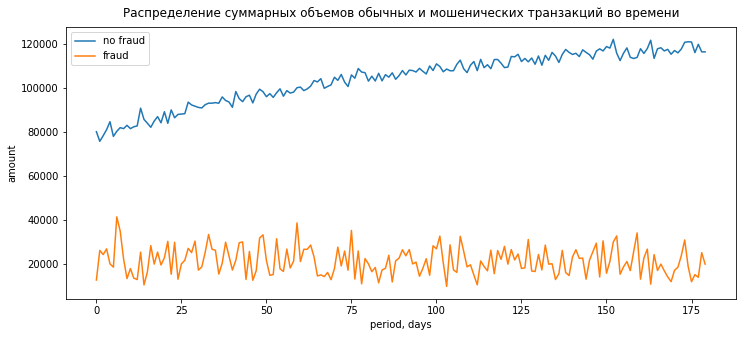

In [ ]:
fig, axes = plt.subplots(figsize=(12,5))

axes.grid(axis='x', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение суммарных объемов обычных и мошенических транзакций во времени', pad = 10)
df[df['fraud']==0].groupby(['step'])['amount'].sum().plot(label='no fraud')
df[df['fraud']==1].groupby(['step'])['amount'].sum().plot(label='fraud')
axes.set_xlabel('period, days')
axes.set_ylabel('amount')
axes.legend()

plt.show()

*На протяжении рассматриваемого периода наблюдается рост совокупного объема обычных транзакций, обусловленный увеличением их количества, среднедневная сумма транзакции, при этом, не увеличивается, колеблется в диапазоне 30-35 у.е.*

*Количество мошеннических транзакций на протяжении исследуемого периода остается постоянным, как и их среднедневная величина, которая имеет бОльшую волатильность, по сравнению с обычными транзакциями (диапазон изменений 530-1032 у.е.)*

Проведем анализ мошеннических сделок в разрезе различных категориальных признаков:

### Оценка данных в разрезе категорий пол/возраст

In [ ]:
clr=sns.color_palette('Spectral_r', n_colors=15)

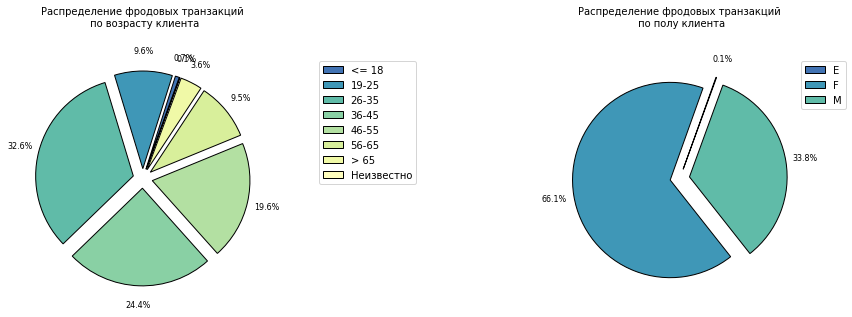

In [ ]:
age_df = df[df['fraud']==1].groupby('age')['age'].count()
gender_df = df[df['fraud']==1].groupby('gender')['gender'].count()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.2, hspace=0.5)

axes[0].set_title('Распределение фродовых транзакций\n по возрасту клиента', fontsize='medium', pad = 30) 
axes[0].pie(x=age_df, radius=1, startangle=70, colors=clr, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize':8},
            autopct='%2.1f%%', explode=[0.1]*len(age_df), pctdistance=1.2, shadow=False)
age_ = {0:'<= 18', 1: '19-25', 2: '26-35', 3: '36-45', 4: '46-55', 5: '56-65', 6: '> 65', 7: 'Неизвестно'}
axes[0].legend(labels=age_.values(), bbox_to_anchor=(1.2, 1))

axes[1].pie(x=gender_df, radius=1, startangle=70, colors=clr, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize':8},
            autopct='%2.1f%%', explode=[0.1]*len(gender_df), pctdistance=1.2, shadow=False)
axes[1].set_title('Распределение фродовых транзакций\n по полу клиента', fontsize='medium', pad = 30) 
axes[1].legend(labels=gender_df.index, bbox_to_anchor=(1.2, 1))

plt.show()

*Для различных возрастных категорий нет четко выраженной закономерности между случаями мошенничества и немошенничества. Наибольшая доля фродовых транзакий (76,6%) приходится на возрастной диапазон с 26 до 55 лет*. 
<br>

*В категории "пол" преобладают транзакции совершенные от лица женщин, однако и здесь нельзя сделать однозначный вывод о взаимосвязи данного признака и факта мошенничества. Доля организаций в мошенических сделках 0,1%, что позволяет утверждать, что транзакции совершенные от лица компаний в большинстве случаев мошенническими не являются.*


Проведем оценку по паре признаков пол/возраст.


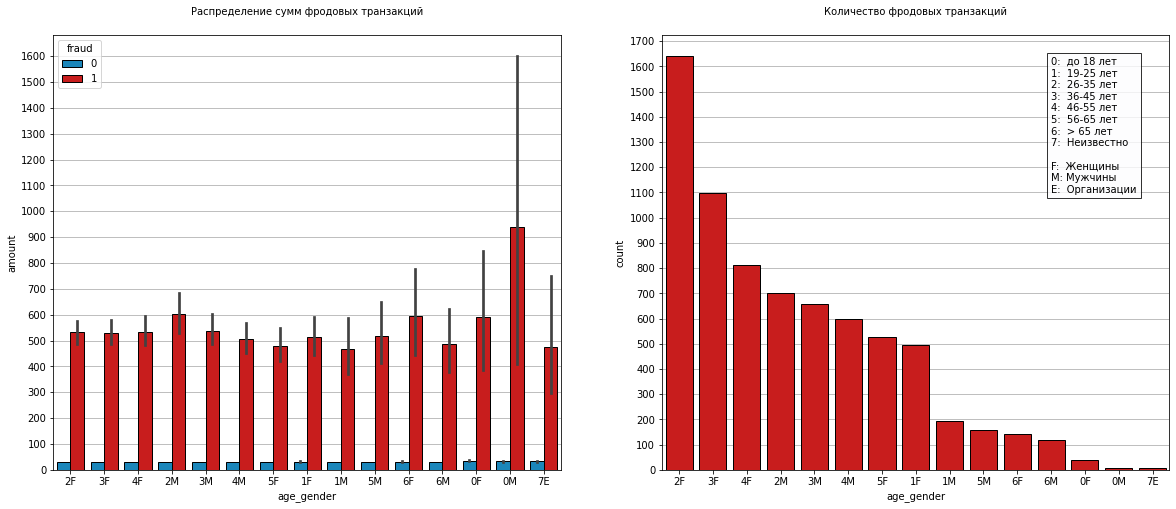

In [ ]:
z= df[df['fraud']==1].groupby('age_gender')['age_gender'].count().sort_values(ascending=False)
clr_ = ['#008fd5', '#e50000']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axes[0].grid(axis='y', which='both', alpha=1)
axes[0].set_axisbelow(True) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
axes[0].set_title('Распределение сумм фродовых транзакций', fontsize='medium', pad = 20) 
sns.barplot(data=df, x='age_gender', y='amount', hue='fraud', order=z.index, palette=clr_, edgecolor='black', ax=axes[0])
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(100))

axes[1].grid(axis='y', which='both', alpha=1)
axes[1].set_axisbelow(True) 
axes[1].set_title('Количество фродовых транзакций', fontsize='medium', pad = 20) 
sns.countplot(data=df[df['fraud']==1], x='age_gender', order=z.index, color=clr_[1], edgecolor='black', ax=axes[1])
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(100))
age_ = '0:  до 18 лет\n1:  19-25 лет\n2:  26-35 лет\n3:  36-45 лет\n4:  46-55 лет\n5:  56-65 лет\n6:  > 65 лет\n7:  Неизвестно\n\nF:  Женщины\nM: Мужчины\nE:  Организации'
plt.text(11, 1100, s=age_, fontsize=10, bbox=dict(edgecolor='black', facecolor='#fdfdfe', alpha=0.8))

plt.show()

*Наибольшее количество мошеннических транзакций было сделано от лица женщин в возрасте от 26 до 45 лет. Наиболее крупные по суммам транзации совершены от лица мужчин в возрасте до 18 лет, при этом, это были единичные случаи.*

### Оценка данных в разрезе отраслевых категорий.

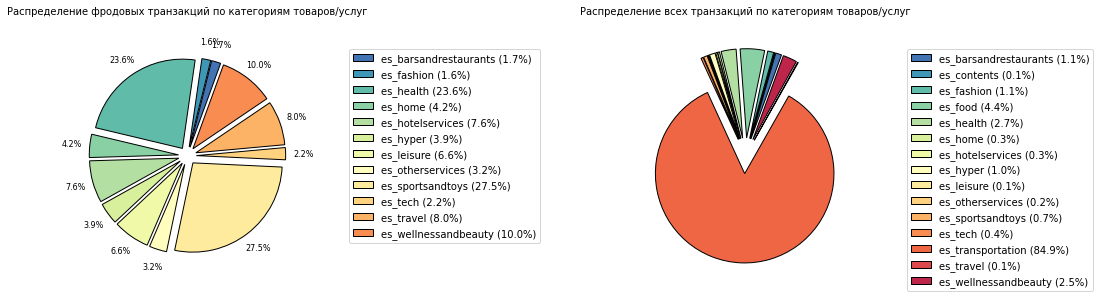

In [ ]:
fraud_df = df[df['fraud']==1].groupby('category')['category'].count()
all_df = df.groupby('category')['category'].count()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.5)

axes[0].set_title('Распределение фродовых транзакций по категориям товаров/услуг', fontsize='medium', pad = 30) 
axes[0].pie(x=fraud_df, radius=1, startangle=70, colors=clr, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize':8},
            autopct='%2.1f%%', explode=[0.1]*len(fraud_df), pctdistance=1.2, shadow=False)
total = sum(fraud_df)
lbls_category = [f"{n} ({v/total:.1%})" for n,v in zip(fraud_df.index, fraud_df)]
axes[0].legend(labels=lbls_category, bbox_to_anchor=(1.2, 1))

axes[1].set_title('Распределение всех транзакций по категориям товаров/услуг', fontsize='medium', pad = 30) 
axes[1].pie(x=all_df, radius=1, startangle=70, colors=clr, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize':8},
            explode=[0.2]*len(all_df), pctdistance=1.2, shadow=False)
total = sum(all_df)
lbls_category = [f"{n} ({v/total:.1%})" for n,v in zip(all_df.index, all_df)]
axes[1].legend(labels=lbls_category, bbox_to_anchor=(1.2, 1))

plt.show()

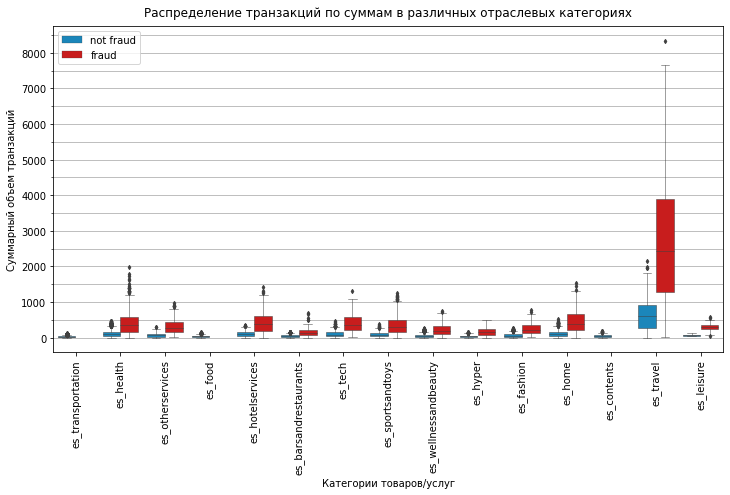

In [ ]:
clr_ = ['#008fd5', '#e50000']
fig, axes = plt.subplots(figsize=(12,6))

axes.grid(axis='y', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение транзакций по суммам в различных отраслевых категориях', pad = 10)
bp = sns.boxplot(data=df, x='category', y='amount', hue='fraud', fliersize=3, linewidth=0.5, palette=clr_, ax=axes)
plt.xticks(rotation=90)
axes.yaxis.set_minor_locator(ticker.MultipleLocator(500))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1000))
axes.set_xlabel('Категории товаров/услуг')
axes.set_ylabel('Суммарный объем транзакций')
legend_labels, _= axes.get_legend_handles_labels()
axes.legend(legend_labels, ['not fraud', 'fraud'], loc='upper left')
plt.show()

*Общая тенденция превышения суммы фродовой транзакции над величиной наблюдаемого максимума обычной транзакции сохраняется для каждой категории товаров и услуг, где был отмечен фрод.* 

*В категориях "контент", "питание" и "транспорт" мошеннические транзакции отсутствуют, при этом на долю покупок в категории "транспорт" приходится почти 85% всей выборки.*


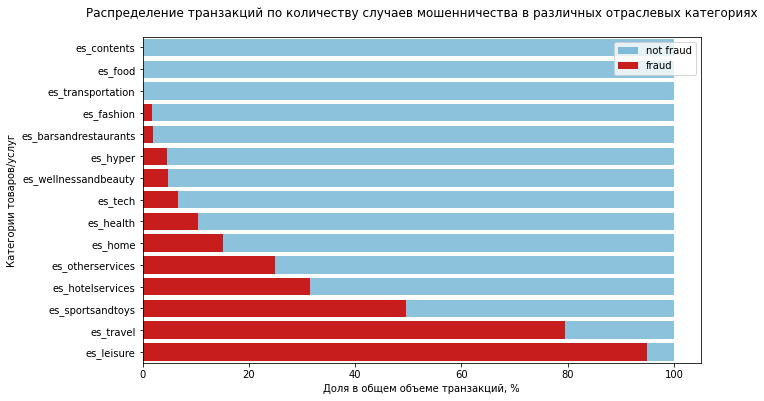

In [ ]:
df_cat = df.groupby('category')[['fraud','category']].agg({'fraud': lambda x: round(x.sum()/x.count()*100, 2),
                                                           'category': lambda x: 100
                                                          })
df_cat.sort_values(by='fraud', inplace=True)
fig, axes = plt.subplots(figsize=(10,6))

axes.grid(axis='y', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение транзакций по количеству случаев мошенничества в различных отраслевых категориях', pad = 20)

sns.barplot(data=df_cat, x='category', y=df_cat.index,
            orient='h', color='#008fd5', label='not fraud', alpha=0.5, ax=axes)
sns.barplot(data=df_cat, x='fraud', y=df_cat.index,
            orient='h', color='#e50000', label='fraud', alpha=1, ax=axes)
    
axes.set_xlabel('Доля в общем объеме транзакций, %')
axes.set_ylabel('Категории товаров/услуг')
legend_labels, _= axes.get_legend_handles_labels()
axes.legend(legend_labels, ['not fraud', 'fraud'], loc='upper right')

plt.show()

*В категориях "спорт и игрушки", "досуг" и "путешествия" половина и более транзакций - мошеннические.*

### Оценка транзакций в разрезе контрагентов сделки

 Для каждого покупателя и продавца вычислим долю фродовых сделок в его истории

In [ ]:
df['cust_fraud_part'] = df.groupby(['customer'])['fraud'].transform(lambda x: x.sum()/x.count())
df['merch_fraud_part'] = df.groupby(['merchant'])['fraud'].transform(lambda x: x.sum()/x.count())

In [ ]:
ccf1 = df[df['cust_fraud_part']>0.05]['customer'].nunique()/df['customer'].nunique()*100
ccf2 = df[df['cust_fraud_part']>0.20]['customer'].nunique()/df['customer'].nunique()*100
cmf = df[df['merch_fraud_part']>0.5]['merchant'].nunique()/df['merchant'].nunique()*100
ccf1, ccf2, cmf


(9.48443579766537, 2.772373540856031, 22.0)

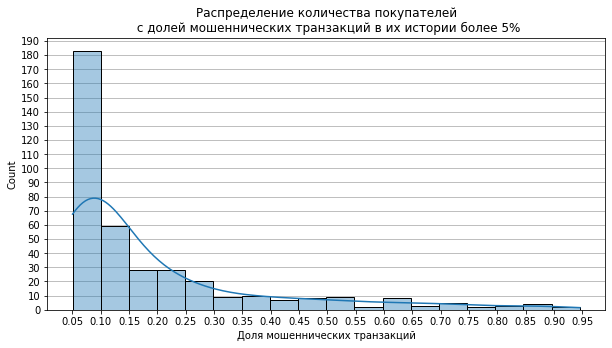

In [ ]:
dc = df[df['cust_fraud_part']>0.05].groupby(['customer'])['cust_fraud_part'].mean()
fig, axes = plt.subplots(figsize=(10,5))
axes.grid(axis='y', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение количества покупателей\n с долей мошеннических транзакций в их истории более 5%')
sns.histplot(data=dc, x=dc.values, kde=True, stat="count", bins=18, alpha= 0.4, ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axes.yaxis.set_major_locator(ticker.MultipleLocator(10))
axes.set_xlabel('Доля мошеннических транзакций')
plt.show()

*У 9,5% покупателей из всех сделанных ими транзакций в 5% случаев зафиксировано мошенничество, а у 2,7% покупателей - случаев мошенничества более 20%. Транзакции, поступающие от покупателей с большой долей мошенничества в истории, требуют дополнительной проверки.*

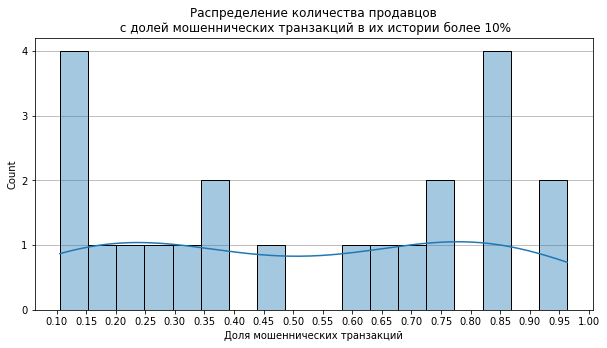

In [ ]:
dc = df[df['merch_fraud_part']>0.1].groupby(['merchant'])['merch_fraud_part'].mean()
fig, axes = plt.subplots(figsize=(10,5))
axes.grid(axis='y', which='both', alpha=1)
axes.set_axisbelow(True) 
axes.set_title('Распределение количества продавцов\n с долей мошеннических транзакций в их истории более 10%')
sns.histplot(data=dc, x=dc.values, kde=True, stat="count", bins=18, alpha= 0.4, ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
axes.yaxis.set_major_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Доля мошеннических транзакций')
plt.show()

*У 40% продавцов на протяжении рассматриваемого периода не было мошеннических транзакций, а у 20% продавцов доля фрода в истории составила более 50%.*

*При анализе транзакции, в случае возникновения подозрений на мошенничество, наличие в качестве контрагента продавцов с высокой долей фрода в истории может рассматриваться как дополнительный аргумент в пользу отнесения сделки к мошеннической.*

**Вывод:** 

*Исходные данные имеют выраженный дисбаланс классов (1,21% фактов мошенничества против 98,79% обычных транзакций).*

*Мошеннические транзакции, чаще чем в других случаях, осуществляются от лица женщин в возрасте от 26 до 45 лет.*

*Наиболее часто фродовые покупки происходят в категориях "спорт и игрушки", "здоровье", "велнес и красота". В категориях "спорт и игрушки", "досуг" и  "путешествия" половина и более транзакций - мошеннические.*

*Суммы фродовых транзакций имеют большой разброс. Для каждой категории характерным признаком мошенической сделки является значительное превышение суммы фрода над средней величиной немошеннической транзакции. Во всех категориях, за исключением категории "путешествия", суммы немошеннических сделок не превышают 500 у.е., тогда как размер фродовой транзакции чаще находится в интервале от 500 до 2000 у.е. В категории "путешествия" платежи по немошенническим сделкам находятся в пределах 2200 у.е., более значительные суммы являются фродовыми транзакциями.*
<br><br><br>
*В качестве базового решения для детекции фактов мошенничества можно ввести порог отсечения по сумме сделки для каждой категории товаров/услуг. Если сумма транзакции попадает в зону "выбросов" для нормальных сделок, т.е. превышает величину $Q3 + 1.5*IQR~$ для нормальны сделок, то такая сделка должна быть помечена как потенциально мошенническая.*

*Также классифицировать транзакцию в мошенническую можно в зависимости от участия в сделке контрагентов с высокой долей фрода в истории (по созданным заранее "черным спискам").* 

*При сомнительной транзакции, дополнительным аргументом в пользу отнесения ее к мошеннической будет выступать принадлежность транзакции к группам с повышенным риском фрода (по полу/возрасту/отраслевой категории).* 

*В качестве метрики для поставленной задачи целесообразно использовать метрику $Recall$, так как выявление факта мошенничества важнее для банка, поскольку пропуск фрода может привести к гораздо большим издержкам, по сравнению с мерами по его предотвращению.*


### Проверка эффективности детекции фрода на основе сделанной эвристики

In [ ]:
df_evr = df.copy()
df_evr.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_gender,cust_fraud_part,merch_fraud_part
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0,4M,0.0,0.0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0,2M,0.0,0.0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0,4F,0.0,0.0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0,3M,0.0,0.0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0,5M,0.0,0.0


In [ ]:
#  Разбиваем выборку на обучение и тест
#  Столбцы, содержащие целевую переменную и производные данные не удаляем из датасета, 
#  так как они не участвуют в расчетах при детекции, но потребуюся для оценки эффективности алгоритма 

from sklearn import model_selection

Yevr = df_evr['fraud']
Xevr_train, Xevr_test, Yevr_train, Yevr_test = model_selection.train_test_split(df_evr, Yevr, test_size=0.3, stratify=Yevr)
Xevr_test.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_gender,cust_fraud_part,merch_fraud_part
105756,38,C1360481565,5,F,M348934600,es_transportation,36.18,0,5F,0.016484,0.0
95440,35,C1928450094,2,M,M1823072687,es_transportation,28.68,0,2M,0.000000,0.0
168474,58,C1839662768,3,F,M348934600,es_transportation,35.88,0,3F,0.030534,0.0
61955,23,C959506480,1,F,M348934600,es_transportation,17.66,0,1F,0.000000,0.0
231674,78,C203802515,1,F,M1823072687,es_transportation,19.71,0,1F,0.000000,0.0


In [ ]:
# вычисляем пороговое значение для суммы фрода по каждой отрасли (категории) на основе имеющейся статистики

up_border_dict = {}
for cat in Xevr_train['category'].unique():
  up_border_dict[cat] = round(up_border(Xevr_train[(Xevr_train['fraud']==0) & (Xevr_train['category']==cat)]['amount']),2)
up_border_dict

{'es_barsandrestaurants': 126.15,
 'es_contents': 139.37,
 'es_fashion': 185.48,
 'es_food': 108.24,
 'es_health': 318.79,
 'es_home': 331.36,
 'es_hotelservices': 318.43,
 'es_hyper': 118.06,
 'es_leisure': 142.22,
 'es_otherservices': 234.29,
 'es_sportsandtoys': 274.7,
 'es_tech': 309.84,
 'es_transportation': 77.35,
 'es_travel': 1979.95,
 'es_wellnessandbeauty': 170.58}

In [ ]:
#  вносим данные в тестовый датасет для дальнейшей классификации
#  с использованием рассчитанного порога

evr_test = Xevr_test.copy()
for cat in evr_test['category'].unique():
  evr_test.loc[evr_test['category']==cat, 'category_up_border'] = up_border_dict[cat]
evr_test.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_gender,cust_fraud_part,merch_fraud_part,category_up_border
105756,38,C1360481565,5,F,M348934600,es_transportation,36.18,0,5F,0.016484,0.0,77.35
95440,35,C1928450094,2,M,M1823072687,es_transportation,28.68,0,2M,0.000000,0.0,77.35
168474,58,C1839662768,3,F,M348934600,es_transportation,35.88,0,3F,0.030534,0.0,77.35
61955,23,C959506480,1,F,M348934600,es_transportation,17.66,0,1F,0.000000,0.0,77.35
231674,78,C203802515,1,F,M1823072687,es_transportation,19.71,0,1F,0.000000,0.0,77.35


In [ ]:
# создаем "черные списки" покупателей и продавцов на основе имеющейся статистики

blacklist_cust = Xevr_train[Xevr_train['cust_fraud_part'] >= 0.5]['customer'].unique()
blacklist_merch = Xevr_train[Xevr_train['merch_fraud_part'] >= 0.8]['merchant'].unique()

In [ ]:
# классифицируем транзакции из тестовой выборки на основе сделанной эвристики

evr_test.loc[(evr_test['amount'] > evr_test['category_up_border']) | 
              evr_test['merchant'].isin(blacklist_merch) |
              evr_test['customer'].isin(blacklist_cust), 'fraud_evr'] = 1
evr_test = evr_test.fillna(0)
evr_test.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_gender,cust_fraud_part,merch_fraud_part,category_up_border,fraud_evr
105756,38,C1360481565,5,F,M348934600,es_transportation,36.18,0,5F,0.016484,0.0,77.35,0.0
95440,35,C1928450094,2,M,M1823072687,es_transportation,28.68,0,2M,0.000000,0.0,77.35,0.0
168474,58,C1839662768,3,F,M348934600,es_transportation,35.88,0,3F,0.030534,0.0,77.35,0.0
61955,23,C959506480,1,F,M348934600,es_transportation,17.66,0,1F,0.000000,0.0,77.35,0.0
231674,78,C203802515,1,F,M1823072687,es_transportation,19.71,0,1F,0.000000,0.0,77.35,0.0


In [ ]:
# функция для печати отчета

def print_param(p0, r0, f0, p1, r1, f1, acc):
  print("============================================")
  print("# classification_report for heuristic model:")
  print("============================================")
  print()
  print("   precision\trecall\t f1-score")
  print("--------------------------------------------")
  print(f' 0\t%0.2f\t %0.2f\t    %0.2f' % (p0, r0, f0))
  print(f' 1\t%0.2f\t %0.2f\t    %0.2f' % (p1, r1, f1))
  print("--------------------------------------------")
  print(f'    accuracy\t\t    %0.2f' % acc)
  

In [ ]:
# вычисляем метрики precision/recall/accuracy 

tn = evr_test[(evr_test['fraud'] == evr_test['fraud_evr']) & (evr_test['fraud'] == 0)]['fraud_evr'].count()
tp = evr_test[(evr_test['fraud'] == evr_test['fraud_evr']) & (evr_test['fraud'] == 1)]['fraud_evr'].count()
fn = evr_test[(evr_test['fraud'] != evr_test['fraud_evr']) & (evr_test['fraud'] == 1)]['fraud_evr'].count()
fp = evr_test[(evr_test['fraud'] != evr_test['fraud_evr']) & (evr_test['fraud'] == 0)]['fraud_evr'].count()
my_pr_0 = round(tn / (tn + fn), 3)
my_re_0 = round(tn / (tn + fp), 3)
my_pr_1 = round(tp / (tp + fp), 3)
my_re_1 = round(tp / (tp + fn), 3)
my_f1_0 = round((2 * my_pr_0 * my_re_0)/(my_pr_0 + my_re_0), 3)
my_f1_1 = round((2 * my_pr_1 * my_re_1)/(my_pr_1 + my_re_1), 3)
my_acc = round((tp+tn)/(tp+tn+fp+fn),3)

print_param(my_pr_0, my_re_0, my_f1_0 , my_pr_1, my_re_1, my_f1_1, my_acc)

# classification_report for heuristic model:

   precision	recall	 f1-score
--------------------------------------------
 0	1.00	 0.99	    0.99
 1	0.55	 0.81	    0.66
--------------------------------------------
    accuracy		    0.99


Выбранный эвристический алгоритм, основанный лишь на построении порога отсечения по сумме транзакции, дает нам значение метрики $Recall$ = (0.52, 0.59), что является не очень хорошим показателем. Дополнительное применение "черных списков" контрагентов повышает оценку до уровня 0.79 - 0.89, в зависимости от установленных порогов риска по покупателям и продавцам соответственно, точность прогноза при этом падает.

## Определение фрода при помощи модели ML

### Подготовка датасета

Очистим датасет от вспомогательных показателей, сформированных для проведения анализа.

In [ ]:
df_clear = df.drop(['age_gender', 'cust_fraud_part', 'merch_fraud_part'], axis=1)
df_clear.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [ ]:
# Выделяем целевую переменную

dfml = df_clear
Y = dfml['fraud'].values
dfml.drop(['fraud'], axis = 1, inplace=True)
dfml.head()

,step,customer,age,gender,merchant,category,amount
0,0,C1093826151,4,M,M348934600,es_transportation,4.55
1,0,C352968107,2,M,M348934600,es_transportation,39.68
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89
3,0,C1760612790,3,M,M348934600,es_transportation,17.25
4,0,C757503768,5,M,M348934600,es_transportation,35.72


Преобразуем категориальные признаки в числовые при помощи метода LabelEncoder.
 

In [ ]:
from sklearn import preprocessing

def number_encode_features(init_df, columns_to_transform):
    result = init_df.copy() 
    encoders = {}
    for column in columns_to_transform:
        encoders[column] = preprocessing.LabelEncoder() 
        result[column] = encoders[column].fit_transform(result[column]) 
    return result, encoders

df_encode, encoders = number_encode_features(dfml, ['gender','customer', 'merchant', 'category']) 
df_encode.head() 


,step,customer,age,gender,merchant,category,amount
0,0,210,4,2,30,12,4.55
1,0,2753,2,2,30,12,39.68
2,0,2285,4,1,18,12,26.89
3,0,1650,3,2,30,12,17.25
4,0,3585,5,2,30,12,35.72


Проверим корреляцию между признаками

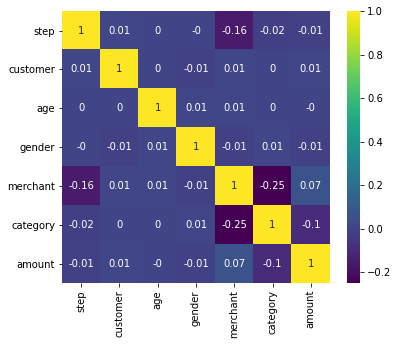

In [ ]:
fig, axes = plt.subplots(figsize=(6,5))
sns.heatmap(round(df_encode.corr(),2), cmap='viridis', annot=True, ax=axes)

Значительной взаимосвязи между признаками не выявлено.


In [ ]:
# Разбиваем выборку на обучение и тест для 

from sklearn import model_selection

dfml = df_encode
X_train_base, X_test_base, Y_train, Y_test = model_selection.train_test_split(dfml, Y, test_size=0.3, stratify=Y)
X_train_base.shape, X_test_base.shape, Y_train.shape, Y_test.shape

((416250, 7), (178393, 7), (416250,), (178393,))

Поскольку в ходе проведенного анализа была выявлена зависимость между суммой транзакции и целевой переменной, для каждого покупателя и продавца вычислим среднее значение суммы всех его транзакций. Внесем данные в датасет. Данная информация, возможно, позволит нам улучшить предсказательный результат модели.

In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()
X_train['customer_mean_amount'] = X_train.groupby(['customer'])['amount'].transform('mean')
X_train['merchant_mean_amount'] = X_train.groupby(['merchant'])['amount'].transform('mean')
X_test['customer_mean_amount'] = X_test.groupby(['customer'])['amount'].transform('mean')
X_test['merchant_mean_amount'] = X_test.groupby(['merchant'])['amount'].transform('mean')


In [ ]:
# Применим масштабирование

from sklearn.preprocessing import StandardScaler

def scale_features(df_train, df_test, columns_to_scale):
    train = df_train.copy() 
    test = df_test.copy() 
    sc = StandardScaler()  
    res_train = sc.fit_transform(train[columns_to_scale])
    res_test = sc.transform(test[columns_to_scale])
    for col in enumerate(columns_to_scale):
        train[col[1]] = res_train[:,col[0]]
        test[col[1]] = res_test[:,col[0]]
    return train, test

X_train, X_test = scale_features(X_train, X_test, ['step', 'customer',	'merchant', 'amount', 'customer_mean_amount', 'merchant_mean_amount'])    

### Выбор базовой модели

Поскольку перед нами задача бинарной классификации, и изначально датасет содержит много категориальных признаков, для построения модели выбираем алгоритм дерева решений.

Рассмотрим две модели: **DecisionTreeClassifier** и **RandomForestClassifier**


In [ ]:
# модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# метрики качества
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import SCORERS

from sklearn.metrics import classification_report


In [ ]:
DTC_model = DecisionTreeClassifier()
DTC_model.fit(X_train, Y_train)

RFC_model = RandomForestClassifier(n_estimators=20)
RFC_model.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
YDT_predict = DTC_model.predict(X_test)
YRF_predict = RFC_model.predict(X_test)

In [ ]:
# Проверим, какие результаты выдают модели на обучающей и тестовой выборке

print("DTC_model - on train set: {}".format(accuracy_score(Y_train, DTC_model.predict(X_train))))
print("DTC_model - on test set: {}".format(accuracy_score(Y_test, YDT_predict)))
print("\n")
print("RFC_model - on train set: {}".format(accuracy_score(Y_train, RFC_model.predict(X_train))))
print("RFC_model - on test set: {}".format(accuracy_score(Y_test, YRF_predict)))


DTC_model - on train set: 1.0
DTC_model - on test set: 0.994691495742546


RFC_model - on train set: 0.9998702702702703
RFC_model - on test set: 0.9962106136451543


Сильного расхождения на обучающей и тестовой выборке не выявлено, следовательно модели не переобучились.

In [ ]:
print("classification_report for DecisionTreeClassifier model:\n")
print(classification_report(Y_test, YDT_predict))

classification_report for DecisionTreeClassifier model:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.77      0.79      0.78      2160

    accuracy                           0.99    178393
   macro avg       0.89      0.90      0.89    178393
weighted avg       0.99      0.99      0.99    178393



In [ ]:
print("classification_report for RandomForestClassifier model:\n")
print(classification_report(Y_test, YRF_predict))

classification_report for RandomForestClassifier model:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    176233
           1       0.89      0.78      0.83      2160

    accuracy                           1.00    178393
   macro avg       0.94      0.89      0.92    178393
weighted avg       1.00      1.00      1.00    178393



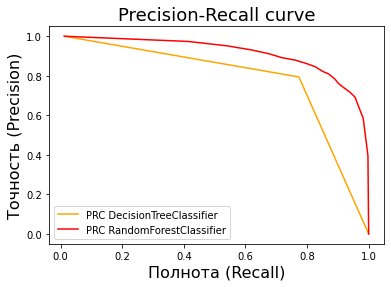

In [ ]:
# Оценим качество моделей по метрике PRC-AUC

test_prob_DC = DTC_model.predict_proba(X_test)[:,1]
test_prob_RF = RFC_model.predict_proba(X_test)[:,1]

precision_DC, recall_DC, _ = precision_recall_curve(Y_test, test_prob_DC)
precision_RF, recall_RF, _ = precision_recall_curve(Y_test, test_prob_RF)

plt.title('Precision/Recall Characteristic (PRC) Curve')
plt.plot(precision_DC, recall_DC, color='orange', label='PRC DecisionTreeClassifier')
plt.plot(precision_RF, recall_RF, color='red', label='PRC RandomForestClassifier')
plt.title('Precision-Recall curve', fontsize=18)
plt.xlabel('Полнота (Recall)', fontsize=16)
plt.ylabel('Точность (Precision)', fontsize=16)
plt.legend()
plt.show()

Модель, построенная на алгоритме "Random Forest" лучше решают нашу задачу. 

### Подбор параметров модели (кросс-валидация)

Проведем подбор параметров модели на кросс-валидации. В качестве метрики будем использовать RECALL, так как выявление факта мошенничества важнее, чем потенциальное недовольство клиентов.

In [ ]:
sorted(SCORERS.keys())

In [ ]:
# Задание параметров кроссвалидации для модели

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle = True)           # разбиение на 5 фолдов
score_ = 'recall'
grid_param = {'n_estimators': [20, 50, 100], 'max_depth': [20, 30], 'max_features':[5, 'sqrt', 'auto']}   # создание сетки параметров модели


In [ ]:
gs = GridSearchCV(estimator=RFC_model,  param_grid=grid_param, cv=skf, scoring=score_, return_train_score=True)
gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_sco

In [ ]:
print("On train set: {}".format(accuracy_score(Y_train, gs.predict(X_train))))
print("On test set: {}".format(accuracy_score(Y_test, gs.predict(X_test))))

On train set: 0.9998462462462463
On test set: 0.99638438727977


In [ ]:
# функция для печати отчета

from sklearn.metrics import classification_report
def print_param(x_test, y_test, clf, score):
# clf   - модель
# score - метрика   
  print("# Tuning hyper-parameters for %s" % score)
  print()

  print("Best parameters set found on development set:")
  print()
  print(clf.best_params_)
  print()
  print("Grid scores on development set:")
  print()
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("Detailed classification report:")
  print()
  print("The model is trained on the full development set.")
  print("The scores are computed on the full evaluation set.")
  print()
  y_true, y_pred = y_test, clf.predict(x_test)
  print(classification_report(y_true, y_pred))
  print()
  return clf

In [ ]:
print_param(X_test, Y_test, gs, score_)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}

Grid scores on development set:

0.797 (+/-0.026) for {'max_depth': 20, 'max_features': 5, 'n_estimators': 20}
0.802 (+/-0.014) for {'max_depth': 20, 'max_features': 5, 'n_estimators': 50}
0.804 (+/-0.021) for {'max_depth': 20, 'max_features': 5, 'n_estimators': 100}
0.791 (+/-0.028) for {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 20}
0.802 (+/-0.020) for {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
0.804 (+/-0.019) for {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
0.797 (+/-0.018) for {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 20}
0.799 (+/-0.022) for {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50}
0.802 (+/-0.023) for {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
0.795 (+/-0.016) for {'max_depth': 30, 'max_features': 5, 'n_estimators': 20}
0.802

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_sco

In [ ]:
RFC_best = RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=100)
RFC_best.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
sorted(list(zip(X_train.columns, RFC_best.feature_importances_)), reverse=True)

[('step', 0.04777375789626242),
 ('merchant_mean_amount', 0.24645378141028756),
 ('merchant', 0.0642959005676931),
 ('gender', 0.006614757064046672),
 ('customer_mean_amount', 0.13691288743708846),
 ('customer', 0.04121254842014997),
 ('category', 0.039319758540868124),
 ('amount', 0.4003272466086426),
 ('age', 0.017089362054961157)]

### SMOTE-балансировка данных

Исходные данные имеют выраженный дисбаланс классов (1,21% фактов мошенничества против 98,79% обычных транзакций).
Для балансировки исходной выборки используем метод SMOTE (метод передискретизации синтетического меньшинства)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
Y_train[Y_train==1].size

5040

In [ ]:
smote = SMOTE(ratio='minority')
X_sm, Y_sm = smote.fit_resample(X_train, Y_train)
 
Y_sm[Y_sm==1].size

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


411210

In [ ]:
RFC_best.fit(X_sm, Y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
Y_pred = RFC_best.predict(X_test)
Y_pred.shape

(178393,)

In [ ]:
print("On train set: {}".format(accuracy_score(Y_sm, RFC_best.predict(X_sm))))
print("On test set: {}".format(accuracy_score(Y_test, Y_pred)))

On train set: 0.7538009776026847
On test set: 0.9772132314608757


In [ ]:
print(classification_report(Y_test, RFC_best.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.53      0.93      0.68      2160

    accuracy                           0.99    178393
   macro avg       0.77      0.96      0.84    178393
weighted avg       0.99      0.99      0.99    178393



## Оценка эффективности различных методик для решения поставленной задачи


In [ ]:
rating = [["Heuristic", 0, 1., 0.99, 0.99],
          ["Heuristic", 1, 0.55, 0.81, 0.66],
          ["RandomForest", 0, 1., 1., 1.],
          ["RandomForest", 1, 0.89, 0.80, 0.84],
          ["RandomForest SMOTE", 0, 1., 0.99, 0.99],
          ["RandomForest SMOTE", 1, 0.53, 0.93, 0.68]]
res = pd.DataFrame(rating, columns=['model', 'class', 'precision', 'recall', 'f1-score'])
res

,model,class,precision,recall,f1-score
0,Heuristic,0,1.00,0.99,0.99
1,Heuristic,1,0.55,0.81,0.66
2,RandomForest,0,1.00,1.00,1.00
3,RandomForest,1,0.89,0.80,0.84
4,RandomForest SMOTE,0,1.00,0.99,0.99
5,RandomForest SMOTE,1,0.53,0.93,0.68


**С учетом выбранной метрики, лучше всего с решением поставленной задачи справляется модель RandomForest SMOTE, однако в этом случае мы существенно проигрываем в точности.**

## Подготовка данных к выгрузке

In [ ]:
def inverse_encode_features(init_df, columns_to_transform, encoder):
    result = init_df.copy() 
    for column in columns_to_transform:
        result[column] = encoder[column].inverse_transform(result[column]) 
    return result

X_test_inverse = inverse_encode_features(X_test_base, ['gender','customer', 'merchant', 'category'], encoders) 
X_test_inverse.head() 

,step,customer,age,gender,merchant,category,amount
130064,46,C2033310172,4,M,M348934600,es_transportation,23.43
254542,85,C72452640,2,F,M1823072687,es_transportation,16.20
85104,31,C506520283,4,F,M348934600,es_transportation,34.12
408144,129,C1506293914,5,M,M151143676,es_barsandrestaurants,61.33
328969,106,C1014313887,5,F,M348934600,es_transportation,60.27


In [ ]:
X_test_inverse['prediction'] = Y_pred

In [ ]:
df_submit = X_test_inverse.sample(5000)
df_submit[df_submit['prediction']==1].count()

step          53
customer      53
age           53
gender        53
merchant      53
category      53
amount        53
prediction    53
dtype: int64

In [ ]:
df_submit.to_csv('./drive/MyDrive/Colab Notebooks/prj3.csv', sep=',', index=False)